<img src="https://courses.edx.org/asset-v1:AlaskaX+SAR-401+3T2020+type@asset+block@blackboard-banner.jpg" width="100%" />

# Glacier Velocity Mapping using Template Matching

<b>Franz J Meyer, University of Alaska Fairbanks; Forrest Williams, Alaska Satellite Facility</b>

This lab will let you exercise template matching techniques for the application of glacier velocity mapping. We will initially perform template matching using cross-correlation techniques on a pair of Sentinel-2 optical images covering an are of south east Alaska that includes Malaspina and Hubbard Glaciers. Subsequently, we will work with a large number of Sentinel-1 image pairs processed using the AutoRIFT algorithm covering the same area. This larger set of images will help understand recent changes in glacier velocity at these glaciers.

<b>This notebook will introduce the following data analysis concepts</b>:

- Using template matching for the application of glacier velocity mapping
- How to order template matching-based offset maps using the AutoRIFT algorithm
- Analysis of glacier velocity changes at Maimport

<hr>

1. Importing Relevant Python Packages, Environment Setup, and Defining Helper Functions

In [2]:
%matplotlib inline
from autoRIFT import autoRIFT
from osgeo import gdal
import numpy as np
import matplotlib.pyplot as plt
import os
import matplotlib.patches as patches
import zipfile
import pandas as pd
import time

In [3]:
# Creating target folder
path = f"{os.getcwd()}/data/imo_in"
if not os.path.exists(path):
    os.makedirs(path)
os.chdir(path)
print(f"Current working directory: {os.getcwd()}")

Current working directory: /home/jupyter/edc-demos/data/imo_in


In [4]:
def load_gdal(infile, band=1, subset=[0,0,None,None]):
    ds = gdal.Open(infile, gdal.GA_ReadOnly)
    
    if not band:
        data = ds.ReadAsArray(*subset)
    else:
        data = ds.GetRasterBand(band).ReadAsArray(*subset)
        
    nodata = ds.GetRasterBand(1).GetNoDataValue()
    mask = data == nodata
    data = np.ma.array(data, mask=mask, fill_value=0)
    projection = ds.GetProjection()
    transform = ds.GetGeoTransform()
    del ds
    return data, transform, projection

## 2. Introduction to the Workflow We Will Use

### 2.1 The Basic Template Matching Approach Used Here

`AutoRIFT` is a template matching python library that is used in production by the [ITS_LIVE project](https://its-live.jpl.nasa.gov) to track glacier velocities across the globe. It determines offsets at a user-specified grid spacing by comparing a square patch of pixels (a "chip") from an earlier image to the pixels in a larger square patch in a later image using an `openCV`-based **Normalized Cross Correlation** method (see figure below). The Normalized Cross Correlation analysis returns a correlation surface at integer pixel offsets between the two image chips which can be used to estimated sub-pixel offsets between the two images. These offsets are determined by finding the peak of the spline of the correlation surface in the vicinity of the highest integer correlation peak. See the image below:

<img src="https://upload.wikimedia.org/wikipedia/commons/6/6a/Convolution_of_box_signal_with_itself2.gif" width="1000" align="center">

## 2.2 Benefits of the AutoRIFT Algorithm

<img style="padding: 0px 0px 0px 10px" src="Figs/TemplateMatching.JPG" width="500" align="right" /> Because `AutoRIFT` takes `numpy` array as inputs, it can be used images of basically any format, with the caveat that the images must have the same resolution and extent. In situations where this is not case, external utilities like `GDAL` can be used to transform the input data and convert it to `numpy`. `AutoRIFT` also outputs a `numpy` array with offsets at a user-specified grid resolution in the same projection as the original images. These arrays can then be written to a variety of geospatial image formats via a external tools (i.e. `GDAl`).

`AutoRIFT` is computationally fast because of the use of `numpy` and the `openCV` library, and so can process an image pair in minutes or tens of minutes depending on the image sizes and requested grid spacing and maximum offset specified for the search. This process can be sped up by using land and ocean masks to limit search distances off of the ice and also by using reference ice flow speed maps to set search distances larger in fast flowing areas and smaller in slow flowing areas, but for simplest uses these are not applied.

## 2.3 AutoRIFT Parameters

- `Temaplate Patch Size:` The size of the template image patch that you use to perform the matching. Larger patches can typically detect smaller offsets, but with lower resolutions.

- `Step Size:` The size of the offset between template image patches, and your output resolution. If your patch size is bigger than your step, your offset measurements will not be independent.

- `Search Distance:` The size of your source image patch, and the maximum distance away from the template patch center that AutoRIFT will search for a match (can also set a minimum in AutoRIFT).

- `Oversampling:` Whether or not to use oversampling to obtain a more specific offset.

<img src="https://www.mdpi.com/remotesensing/remotesensing-13-00749/article_deploy/html/images/remotesensing-13-00749-g001.png" width="1000" align="center">

a) Template matching using normalized cross-correlation, and (b,c) the nested grid design in Autonomous Repeat Image Feature Tracking (AutoRIFT), where (b) shows the image grid and (c) shows the geographic grid. In (b,c), original chips are shown as black, dotted rectangles with the center grid point as a black dot, and chips enlarged by a factor of two (that iteratively progresses) are shown as red, dashed rectangles with the center grid point as a red dot.

Oversampling may allow you to better estimate offsets, but it will increase processing times and may lead to overly-specific results.

<img style="padding: 10px 10px 10px 10px" src="Figs/oversampling.png" width="1000" align="center" />

# 3. Exercising AutoRIFT on a Sentinel-2 Image Pair over Malaspina Glacier

We will use a pair of Sentinel-2 images acquired in May 2020 to demonstrate how `AutoRIFT` works and which parameters it needs for creating an offset field. You can replicate this run by replacing the image pairs used below.

We first get two Sentinel 2 images from the [AWS S2 Level2A CloudOptimizedGeotiff (COG) public data archive](https://registry.opendata.aws/sentinel-2-l2a-cogs/)

## 3.2 Running AutoRIFT to Perform Template Matching-based Rock Glacier Velocity Mapping 

We now will run the `AutoRIFT` algorithm to perform template matching on the image pair. The first thing we'll do is define a helper function. This function takes AutoRIFT's main processing parameters as inputs, but abstracts away some of the nitty-gritty details so that you can perform analyses quickly.

In [5]:
def prep_autorift(reference, secondary, step=32, min_patch=64, max_patch=256, min_search_distance=0, max_search_distance=64, oversample=None):
    # intizialize
    obj = autoRIFT()

    # set imagery
    obj.I1 = reference.astype(np.float32)
    obj.I2 = secondary.astype(np.float32)

    # sampling
    obj.SkipSampleX = step
    obj.SkipSampleY = step
    
    # oversampling
    if oversample:
        obj.OverSampleRatio = oversample

    # chip size
    obj.ChipSizeMinX = min_patch
    obj.ChipSizeMaxX = max_patch
    obj.ChipSize0X = float(16)
    obj.ScaleChipSizeY = int(1)

    # search Area
    obj.minSearch = min_search_distance
    obj.SearchLimitX = max_search_distance
    obj.SearchLimitY = max_search_distance

    # result grid
    m, n = reference.shape
    xVals = np.arange(obj.SkipSampleX, n - obj.SkipSampleX, obj.SkipSampleX)
    yVals = np.arange(obj.SkipSampleY, m - obj.SkipSampleY, obj.SkipSampleY)
    ncol = int(xVals.shape[0])
    nrow = int(yVals.shape[0])
    xGrid = np.repeat(np.reshape(xVals, (1, ncol)), nrow, axis=0)
    yGrid = np.repeat(np.reshape(yVals, (nrow, 1)), ncol, axis=1)
    obj.xGrid = xGrid
    obj.yGrid = yGrid

    return obj

Next we'll read in the input data and subset it to our area of interest.

In [6]:
#bounds = np.s_[1000:7500, 0:5000]
ref, tr, pr = load_gdal('imo_20230805_50cm_final.tif')
#ref = ref[bounds]
sec, ts, ps = load_gdal('imo_2025_50cm_final.tif')
#sec = sec[bounds]

/opt/conda/envs/autorift/lib/python3.11/site-packages/osgeo/gdal.py:311: FutureWarning: Neither gdal.UseExceptions() nor gdal.DontUseExceptions() has been explicitly called. In GDAL 4.0, exceptions will be enabled by default.
  warnings.warn(
ERROR 4: imo_20230805_50cm_final.tif: No such file or directory


AttributeError: 'NoneType' object has no attribute 'GetRasterBand'

In [6]:
#display transform and projection information (will need this for writing autoRIFT output)
print(tr)

print(pr)

(259590.0, 0.5, 0.0, 4203653.0, 0.0, -0.5)
PROJCS["WGS 84 / UTM zone 13N",GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84",6378137,298.257223563,AUTHORITY["EPSG","7030"]],AUTHORITY["EPSG","6326"]],PRIMEM["Greenwich",0,AUTHORITY["EPSG","8901"]],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],AUTHORITY["EPSG","4326"]],PROJECTION["Transverse_Mercator"],PARAMETER["latitude_of_origin",0],PARAMETER["central_meridian",-105],PARAMETER["scale_factor",0.9996],PARAMETER["false_easting",500000],PARAMETER["false_northing",0],UNIT["metre",1,AUTHORITY["EPSG","9001"]],AXIS["Easting",EAST],AXIS["Northing",NORTH],AUTHORITY["EPSG","32613"]]


Let's take a look at our input images.

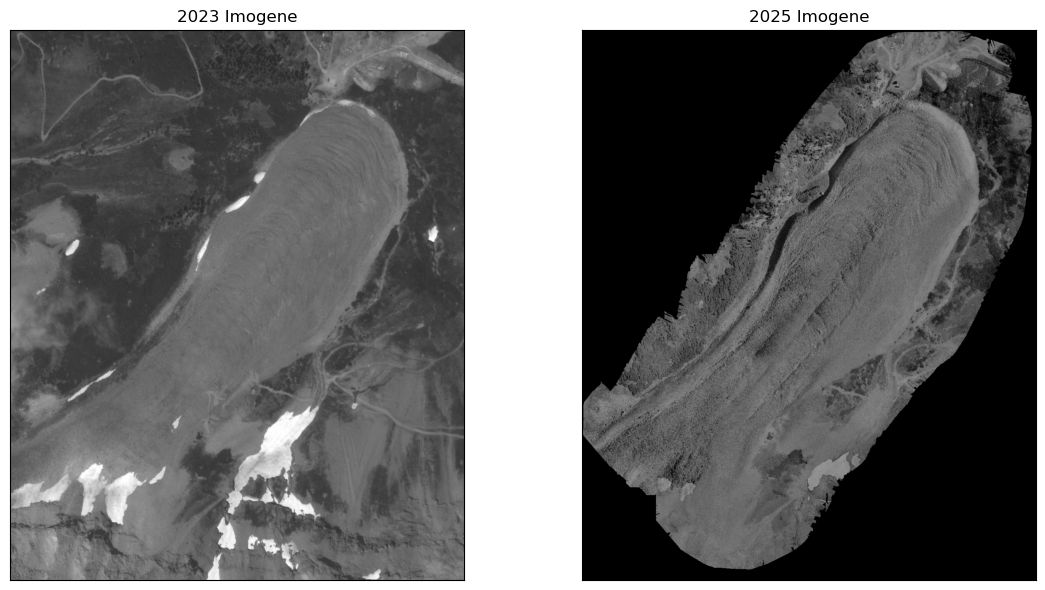

In [7]:
%matplotlib inline
import matplotlib.pyplot as plt

img_color_opts = {'vmin': 0, 'vmax': 500, 'cmap': 'Greys_r'}

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))

dx_plot = ax1.imshow(ref, **img_color_opts)
ax1.set(title='2023 Imogene', aspect='equal', xticks=[], yticks=[])

dy_plot = ax2.imshow(sec, **img_color_opts)
ax2.set(title='2025 Imogene', aspect='equal', xticks=[], yticks=[])

f.tight_layout()
plt.show()

Now we'll actually run AutoRIFT. We first prep the AutoRIFT processing object, then we make sure the inputs have a uniform data type, next we filter the input data using a high-pass filter to reduce the noise in our analysis, then finally we run the template matching.

You'll see some warnings pop up when you run AutoRIFT. Don't mind those.

In [8]:
# Run autoRIFT

start_time = time.time()  # Record the start time


step = 4
result = prep_autorift(ref, sec, step=step)
result.uniform_data_type()
result.preprocess_filt_hps()
result.runAutorift()




end_time = time.time()    # Record the end time
execution_time = end_time - start_time
print(f"Execution time: {execution_time:.4f} seconds for step=")
print(step)

# #set transform for output 
# tr_out = tr
# tr_out(1) = tr(1)*step
# tr_out(5) = tr(5)*step

#initially threw an error where the code was trying to call np.lib.pad --> needed to go into the source code and change all instances of np.lib.pad to np.pad

/opt/anaconda3/envs/autoRIFT/lib/python3.13/site-packages/autoRIFT/autoRIFT.py:1605: RuntimeWarning: divide by zero encountered in divide
  DxMadmin = np.ones(Dx.shape) / OverSampleRatio / SearchLimitX * 2
/opt/anaconda3/envs/autoRIFT/lib/python3.13/site-packages/autoRIFT/autoRIFT.py:1606: RuntimeWarning: divide by zero encountered in divide
  DyMadmin = np.ones(Dy.shape) / OverSampleRatio / SearchLimitY * 2
/opt/anaconda3/envs/autoRIFT/lib/python3.13/site-packages/autoRIFT/autoRIFT.py:1605: RuntimeWarning: divide by zero encountered in divide
  DxMadmin = np.ones(Dx.shape) / OverSampleRatio / SearchLimitX * 2
/opt/anaconda3/envs/autoRIFT/lib/python3.13/site-packages/autoRIFT/autoRIFT.py:1606: RuntimeWarning: divide by zero encountered in divide
  DyMadmin = np.ones(Dy.shape) / OverSampleRatio / SearchLimitY * 2


Execution time: 6.2275 seconds for step=
4


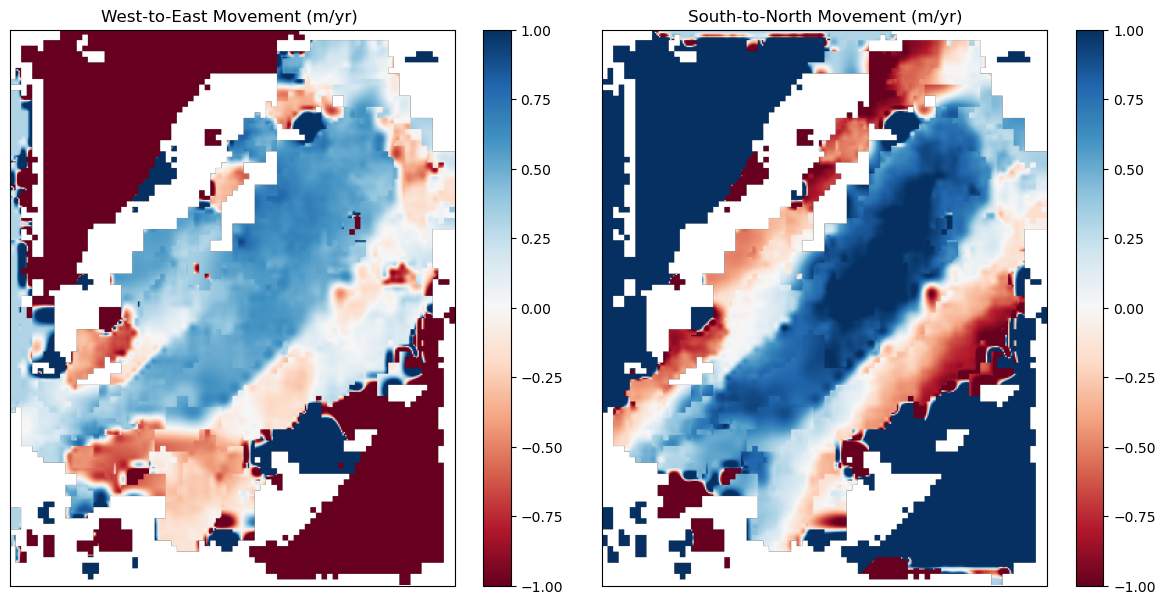

In [10]:
#plot results
%matplotlib inline
import matplotlib.pyplot as plt

px_in = 0.5 #pixel size of input (m)
interval = 2 #time interval in years

dVx = result.Dx  * px_in/interval
dVy = result.Dy  * px_in/interval

dVx_corrected = dVx + 0.3
dVy_corrected = dVy + 0.3

vel_color_opts = {'vmin': -1, 'vmax': 1, 'cmap': 'RdBu'}

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))

#removed step coefficient from plot - does result.Dx return all values in the number of ls at the input image's resolution
dx_plot = ax1.imshow(dVx_corrected, **vel_color_opts)
#dx_plot = ax1.imshow(result.Dx / step, **vel_color_opts)
ax1.set(title='West-to-East Movement (m/yr) ', aspect='equal', xticks=[], yticks=[])

dy_plot = ax2.imshow(dVy_corrected, **vel_color_opts)
# dy_plot = ax2.imshow(result.Dy / step, **vel_color_opts)
ax2.set(title='South-to-North Movement (m/yr)', aspect='equal', xticks=[], yticks=[])

f.colorbar(dx_plot, ax=ax1)
f.colorbar(dy_plot, ax=ax2)
f.tight_layout()
plt.show()

In [11]:
#Write data 
# Creating target folder
path_out = f"{os.getcwd()}/../imo_out/2023-2025"
if not os.path.exists(path_out):
    os.makedirs(path_out)
os.chdir(path_out)
print(f"Current working directory: {os.getcwd()}")

Current working directory: /Users/tylermeng/Documents/fieldwork/ouray2025/autorift/data/imo_out/2023-2025


In [12]:
#Write dx results
[rows, cols] = result.Dx.shape
#[rows_in, cols_in] = ref

print(rows)
print(cols)


new_tr = (259590.0, px_in*step, 0.0, 4203653.0, 0.0, -px_in*step)

#for step=1, dimensions are: 12832, 7168
#step=2: 6416, 3584 - need to re export 
#step =4: 3200, 1792

400
320


In [13]:
arr_out = dVx
outFileName = "imo_dX_step4.tif"
driver = gdal.GetDriverByName("GTiff")
outdata = driver.Create(outFileName, cols, rows, 1, gdal.GDT_Float32)
outdata.SetGeoTransform(new_tr)##sets same geotransform as input
outdata.SetProjection(pr)##sets same projection as input
outdata.GetRasterBand(1).WriteArray(arr_out)
outdata.GetRasterBand(1).SetNoDataValue(10000)##if you want these values transparent
outdata.FlushCache() ##saves to disk!!
outdata = None
band=None
ds=None

In [14]:
#Write dy results
[rows, cols] = result.Dy.shape
arr_out = dVy
outFileName = "imo_dY_step4.tif"
driver = gdal.GetDriverByName("GTiff")
outdata = driver.Create(outFileName, cols, rows, 1, gdal.GDT_Float32)
outdata.SetGeoTransform(new_tr)##sets same geotransform as input
outdata.SetProjection(pr)##sets same projection as input
outdata.GetRasterBand(1).WriteArray(arr_out)
outdata.GetRasterBand(1).SetNoDataValue(10000)##if you want these values transparent
outdata.FlushCache() ##saves to disk!!
outdata = None
band=None
ds=None

In [15]:
#apply static corrections
arr_out = dVx_corrected
outFileName = "imo_dX_step4_corrected.tif"
driver = gdal.GetDriverByName("GTiff")
outdata = driver.Create(outFileName, cols, rows, 1, gdal.GDT_Float32)
outdata.SetGeoTransform(new_tr)##sets same geotransform as input
outdata.SetProjection(pr)##sets same projection as input
outdata.GetRasterBand(1).WriteArray(arr_out)
outdata.GetRasterBand(1).SetNoDataValue(10000)##if you want these values transparent
outdata.FlushCache() ##saves to disk!!
outdata = None
band=None
ds=None

[rows, cols] = result.Dy.shape
arr_out = dVy_corrected
outFileName = "imo_dY_step4_corrected.tif"
driver = gdal.GetDriverByName("GTiff")
outdata = driver.Create(outFileName, cols, rows, 1, gdal.GDT_Float32)
outdata.SetGeoTransform(new_tr)##sets same geotransform as input
outdata.SetProjection(pr)##sets same projection as input
outdata.GetRasterBand(1).WriteArray(arr_out)
outdata.GetRasterBand(1).SetNoDataValue(10000)##if you want these values transparent
outdata.FlushCache() ##saves to disk!!
outdata = None
band=None
ds=None



In [16]:
#convert to magnitude and direction from corrected components 

#apply correction 
dx = dVx_corrected 
dy = dVy_corrected
arr_out = np.sqrt(np.square(dy) + np.square(dx))
outFileName = "imo_magnitude.tif"
driver = gdal.GetDriverByName("GTiff")
outdata = driver.Create(outFileName, cols, rows, 1, gdal.GDT_Float32)
outdata.SetGeoTransform(new_tr)##sets same geotransform as input
outdata.SetProjection(pr)##sets same projection as input
outdata.GetRasterBand(1).WriteArray(arr_out)
outdata.GetRasterBand(1).SetNoDataValue(10000)##if you want these values transparent
outdata.FlushCache() ##saves to disk!!
outdata = None
band=None
ds=None

arr_out = (np.degrees(np.atan2(dx, dy)))
outFileName = "imo_bearing.tif"
driver = gdal.GetDriverByName("GTiff")
outdata = driver.Create(outFileName, cols, rows, 1, gdal.GDT_Float32)
outdata.SetGeoTransform(new_tr)##sets same geotransform as input
outdata.SetProjection(pr)##sets same projection as input
outdata.GetRasterBand(1).WriteArray(arr_out)
outdata.GetRasterBand(1).SetNoDataValue(10000)##if you want these values transparent
outdata.FlushCache() ##saves to disk!!
outdata = None
band=None
ds=None

# 4. Stack of Velocity Maps over Malaspina Glacier Generated using AutoRIFT

We have seen in the previous example how effective template matching can be for the application of glacier velocity mapping. BUT, we've also seen that the process of template matching is time-consuming. Therefore, **offloading the process of ice velocities mapping to an automatic service** is appealing, especially when one is interested in mapping glacier motion across a longer time span.

<div class="alert alert-success">
<font size="4"> <b>USE ASF SERVICES TO GENERATE LOTS OF AUTORIFT DATA QUICKLY AND AUTOMATICALLY!</b></font> 
<br>

In partnership with the ITS_LIVE project, the Alaska Satellite Facility has recently made the template-tracking based AutoRIFT processor available through its search interface Vertex. To order AutoRIFT data, follow the following general workflow:

<ol type="1">
  <li><b>Go to the ASF Vertex search interface at <a href="https://search.asf.alaska.edu/" target="_blank">https://search.asf.alaska.edu/</a></b>
  <li><b>Search for Sentinel-1 Single Look Complex (SLC) images</b> over your area of interest.
  <li><b>Use the SBAS search to create image pairs for AutoRIFT processing.</b>
  <li><b>Click on the "custom processing icon (three nested squares)</b> to submit your jobs.
</ol>      

</div>

## 4.1 Retrieving AutoRIFT Stack over Malaspina Glacier

Using the approach described above, I have ordered 1-year worth of AutoRIFT velocity maps from <b><a href="https://search.asf.alaska.edu/" target="_blank">ASF</a></b>. In total, I have collected 70 glacier velocity estimates over this time period, using 12-day and 24-day Sentinel-1 SAR pairs.

I have prepared these data sets and deposited them for you in an AWS S3 storage bucket. In a first step, we will <b>download these data and unzip them</b> into a folder called ```data```.

In [13]:
!aws --region=us-west-2 --no-sign-request s3 cp s3://asf-jupyter-data-west/MalaspinaAutoRIFT.zip MalaspinaAutoRIFT.zip

download: s3://asf-jupyter-data-west/MalaspinaAutoRIFT.zip to ./MalaspinaAutoRIFT.zip


In [14]:
with zipfile.ZipFile('MalaspinaAutoRIFT.zip', 'r') as zip_obj:
   zip_obj.extractall()

## 4.2 Create Stack And Explore Data Dimensions

We first <b>define two python functions</b> to identify all of our ```AutoRIFT``` Tiff files and to extract the image dates for these files. Because I am lazy, I am using the date of the reference image here. A more sophisticated approach could be to use the mean date between reference and secondary image.

In [15]:
def get_tiff_paths(paths):
    tiff_paths = !ls $paths | sort -t_ -k5,5
    return tiff_paths

def get_dates(pths):
    dates = []
    for p in pths:
        for name_chunk in p.split('/')[-1].split('_'):
            nums = list(range(48, 58))
            if len(name_chunk) == 15 and ord(name_chunk[0]) in nums:
                date = name_chunk.split('T')[0]
                dates.append(date)
                break
    dates.sort()
    return dates

Now we <b>use these functions</b> to identify our GeoTIFFs and extract associated image dates.

In [16]:
paths = "*S1*.tif*"
tiff_paths = get_tiff_paths(paths)
dates=get_dates(tiff_paths)

We also <b>create a Pandas time index</b> fpr our data and print the image dates. You see we have 70 image pairs in our stack with reference image times between Jan 09, 2021 and March 29, 2022

In [17]:
time_index = pd.DatetimeIndex(dates)

for jacqdate, acqdate in enumerate(time_index):
    print('{:4d} {}'.format(jacqdate, acqdate.date()),end=' ')
    if (jacqdate % 5 == 4):
        print()

   0 2021-01-09    1 2021-01-09    2 2021-01-21    3 2021-01-21    4 2021-02-02 
   5 2021-02-02    6 2021-02-14    7 2021-02-14    8 2021-02-26    9 2021-02-26 
  10 2021-03-10   11 2021-03-10   12 2021-03-22   13 2021-03-22   14 2021-04-03 
  15 2021-04-03   16 2021-04-15   17 2021-04-15   18 2021-04-27   19 2021-04-27 
  20 2021-05-09   21 2021-05-09   22 2021-05-21   23 2021-05-21   24 2021-06-02 
  25 2021-06-02   26 2021-06-14   27 2021-06-14   28 2021-06-26   29 2021-06-26 
  30 2021-07-08   31 2021-07-08   32 2021-07-20   33 2021-08-13   34 2021-08-13 
  35 2021-08-25   36 2021-08-25   37 2021-09-06   38 2021-09-06   39 2021-09-18 
  40 2021-09-18   41 2021-09-30   42 2021-09-30   43 2021-10-12   44 2021-10-12 
  45 2021-10-24   46 2021-10-24   47 2021-11-05   48 2021-11-05   49 2021-11-17 
  50 2021-11-17   51 2021-11-29   52 2021-11-29   53 2021-12-11   54 2021-12-11 
  55 2021-12-23   56 2021-12-23   57 2022-01-04   58 2022-01-04   59 2022-01-16 
  60 2022-01-16   61 2022-01

Now we <b>read the data</b> and mask out values associated with bad matches.

In [18]:
rasterstack_masked = np.ma.stack([load_gdal(x)[0] for x in tiff_paths])
rasterstack_masked = np.rot90(rasterstack_masked, k=1, axes=(1,2))

## 4.3 Visualize Mean Glacier Velocity and Enable Extracting of Pixel-by-Pixel Velocity Time Series Extraction

We will now visualize an average velocity image in a way that we can move our mouse over the image and visualize the line/sample image coordinates. This will help us create time-series information for the most interesting image locations.

In [19]:
temporal_mean = np.nanmean(rasterstack_masked, axis=0)

To do so, we first **create some helper functions:**

In [20]:
import warnings

warnings.filterwarnings('ignore')

class pixelPicker:
    def __init__(self, image, width, height):
        self.x = None
        self.y = None
        self.fig = plt.figure(figsize=(width, height))
        self.ax = self.fig.add_subplot(111, visible=False)
        self.rect = patches.Rectangle(
            (0.0, 0.0), width, height,
            fill=False, clip_on=False, visible=False
        )

        self.rect_patch = self.ax.add_patch(self.rect)
        self.cid = self.rect_patch.figure.canvas.mpl_connect('button_press_event',self)
        self.image = image
        self.plot = self.gray_plot(self.image, fig=self.fig, return_ax=True)
        self.plot.set_title('Select a Point of Interest')


    def gray_plot(self, image, vmin=None, vmax=None, fig=None, return_ax=False):
        '''
        Plots an image in grayscale.
        Parameters:
        - image: 2D array of raster values
        - vmin: Minimum value for colormap
        - vmax: Maximum value for colormap
        - return_ax: Option to return plot axis
        '''
        if vmin is None:
            vmin = np.nanpercentile(self.image, 10)
        if vmax is None:
            vmax = np.nanpercentile(self.image, 99)
        if fig is None:
           my_fig = plt.figure()
        ax = fig.add_axes([0.1,0.1,0.8,0.8])
        pos = ax.imshow(image, cmap= 'Blues' , interpolation='nearest', vmin=vmin, vmax=vmax)
        cbar = fig.colorbar(pos, ax=ax, shrink=0.7)
        cbar.set_label('Velocity in m/yr', rotation=270)
        if return_ax:
            return(ax)


    def __call__(self, event):
        print('click', event)
        self.x = event.xdata
        self.y = event.ydata
        for pnt in self.plot.get_lines():
            pnt.remove()
        plt.plot(self.x, self.y, 'ro')


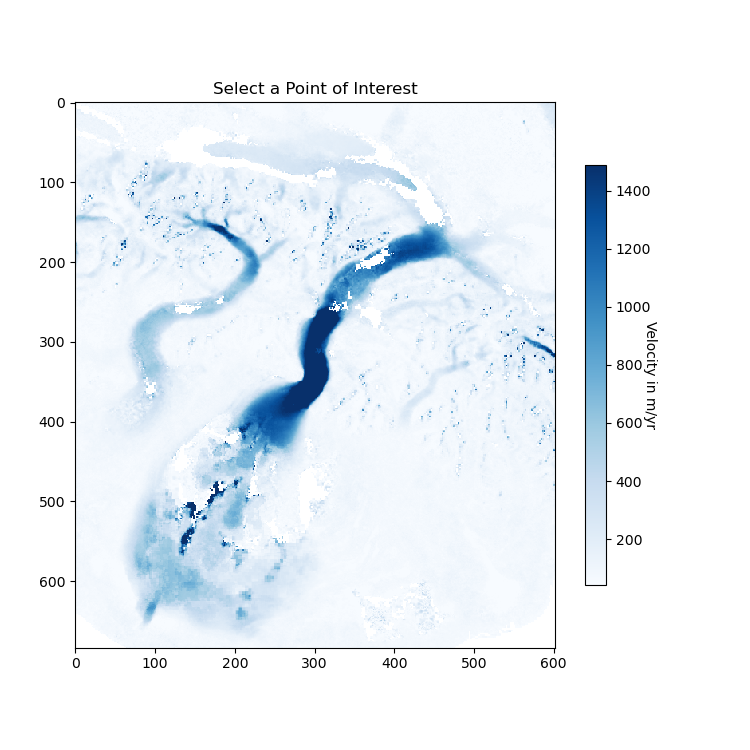

In [21]:
%matplotlib widget
import matplotlib.pyplot as plt
fig_xsize = 7.5
fig_ysize = 7.5
my_plot = pixelPicker(temporal_mean, fig_xsize, fig_ysize)

**Save the selected coordinates:**

In [22]:
if (my_plot.x == None) | (my_plot.y == None):
    sarloc = (300,350)
else:
    sarloc = (int(np.ceil(my_plot.x)), int(np.ceil(my_plot.y)))
print(sarloc)

(302, 342)


## 4.4 Plot Glacier Velocity Time Series at Point Locations

You've picked a location of interest above. Now, let's **pick a ```[5x5]```-sized rectangle around a center pixel which we selected ...**

In [23]:
extent = (5, 5) # choose a 5 by 5 rectangle
bounds = np.s_[:, sarloc[1]:sarloc[1]+extent[1], sarloc[0]:sarloc[0]+extent[0]]

**... and extract the time series for this small area around the selected center pixel in a memory-efficient way (needed for larger stacks):**

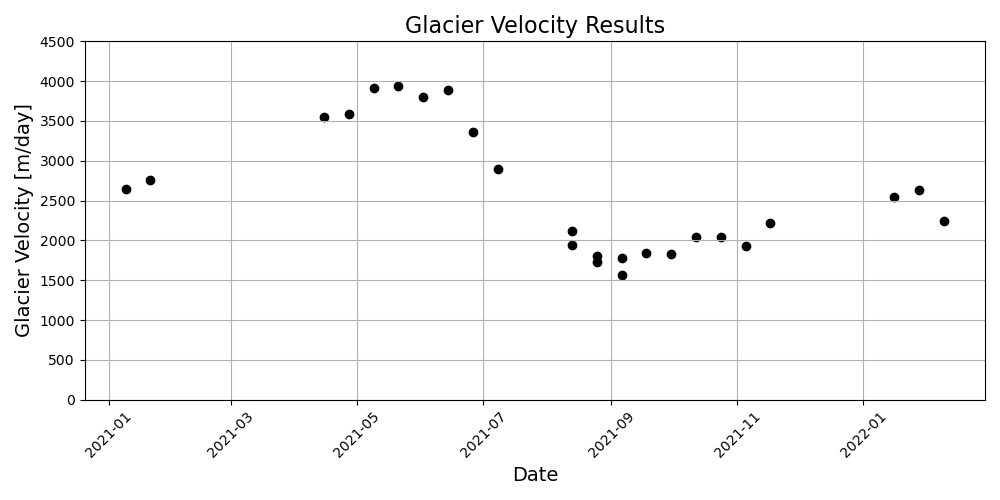

In [24]:
plt.rcParams['xtick.labelsize'] = 10
plt.rcParams['ytick.labelsize'] = 10

subset = rasterstack_masked[bounds]
aggregated = np.nanmean(subset,axis=(1,2))

fig, ax = plt.subplots(1, 1, figsize=(10, 5))
plt.title('Glacier Velocity Results', fontsize=16)
ax.scatter(time_index[~aggregated.mask], aggregated[~aggregated.mask], color='k', marker='o')
ax.set_xlabel('Date', fontsize=14)
ax.set_ylabel('Glacier Velocity [m/day]', fontsize=14)
plt.xticks(rotation = 45)
ax.set_ylim([0, 4500])
plt.grid()
fig.tight_layout()

## 4.5 Important additional topics

Here are a few tips for performing your own pixel-offset analyses:

1. For SAR data, Range and azimuth offsets need to be transformed to geographic coordinates, e.g. East-North-Up. While the azimuth offsets are only sensitive to horizontal displacements, the range offsets are also sensitive to vertical displacements due to the incidence angle.

2. Explore offset processing parameters, including window size, search window size, and filter window size. It's possible that a different set of parameter values will result in higher-quality offset maps.

3. In general, larger window sizes allow you detect slower movement, but you'll also lose resolution as your window size increases.

## 4.6 Should I use feature tracking?

Feature tracking is **great** when:
- Movement is faster than the maximum detectable by InSAR
- You know that most of your movement is horizontal
- You have high-resolution imagery


Feature tracking is **bad** when:
- Movement is very slow
- Movement is mostly in the vertical direction
- You have low-resolution data
- Your imagery has some banding issues (MUST PRE-PROCESS THE DATA!)
- The features you are tracking are being removed from the scene

# <font color='rgba(200,0,0,0.2)'>5. Short Data Exploration Homework Assignment</font>

<br>
<div class="alert alert-danger">
<font size="5"> <b> <font color='rgba(200,0,0,0.2)'> <u>ASSIGNMENT</u>:  </font> Find an Interesting Point and Describe the Movement Patterns You See:  </b> </font>

Please explore several points on the map by going back to the average velocity figure, selecting a different point, and running the code cells under the average velocity figure again. Once you found an area that looks interesting to you, select a point, plot the velocity time series, and <b><i>briefly describe your interpretation of the velocity time series in the markdown cell below</i></b>.
</div>

<div class="alert alert-danger">
<font size="4"> <b> <font color='rgba(200,0,0,0.2)'> </font> Your Interpretation of the Velocity Time Series: </b> </font>

Your words ...
</div>

<hr>

# 6. Version Log

<font size="2"> <i>Geo_SinC -  August 2022 
    <br>
        <b>Version Changes:</b>
    <ul>
        <li>remove obsolete asf_notebook functions</li>
        <li>url_widget</li>
        <li>Adjust some of the language in the notebook</li>
    </ul>
    </i>
</font>